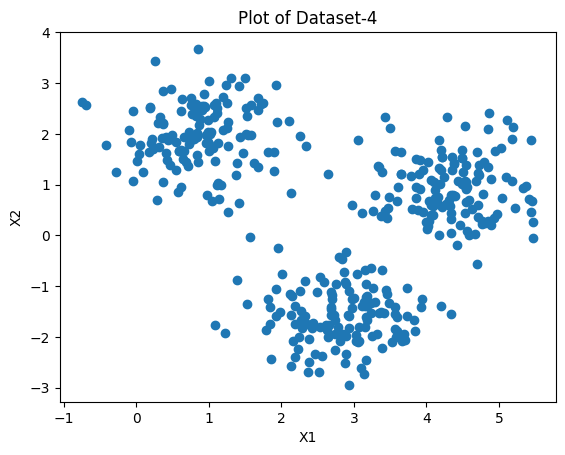

In [12]:
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np
import math
import csv

data=pd.read_csv('A2Q3.csv',header=None)

col1=data[data.columns[0]]
col2=data[data.columns[1]]

x=col1.tolist()
y=col2.tolist()

plt.scatter(x,y)
plt.title('Plot of Dataset-4')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [16]:
class GMM:
  def __init__(self,dat,k):
    dim=len(dat.columns)
    points=len(dat.index)

    shufdata=dat.sample(frac=1)
    datas=np.array_split(shufdata,k)

    X=[]
    for i in range(0,k):
      x=[]
      for j in range(0,dim):
        col=datas[i][datas[i].columns[j]]
        x.append(col.tolist())
      X.append(x)

    weights=[]
    for i in range(0,k):
      size=len(datas[i].index)
      weights.append(size/points)

    means=[]
    for i in range(0,k):
      mean=[]
      for j in range(0,dim):
        mean.append(np.average(X[i][j]))
      means.append(mean)

    covars=[]
    for i in range(0,k):
      tup=[]
      for j in range(0,dim):
        tup.append(X[i][j])
      tup=tuple(tup)
      covar=np.stack(tup,axis=0)
      covar=np.cov(covar)
      covars.append(covar)

    self.data=dat
    self.clusters=k
    self.dim=dim
    self.points=points
    self.weights=weights
    self.means=means
    self.covars=covars
    self.N=[]
    self.resp=[]
    self.logs=[]
    self.prev=self.log_likelihood()
    self.labels=[]
    self.iter=0
    self.p=0
    self.SHS=0

  def gaussian(self,datmat,mean,covar):
    cmean=[]
    cmean.append(mean)
    cmean=np.transpose(cmean)
    a=np.subtract(datmat,cmean)
    at=np.transpose(a)
    inv=np.linalg.inv(covar)
    b=np.dot(at,inv)
    c=np.dot(b,a)
    num=math.exp(-0.5*c[0][0])
    den=(math.sqrt(math.pow((2*math.pi),self.dim)*((np.linalg.det(covar)))))

    return num/den


  def E_step(self):
    datmats=self.data.values.tolist()
    resp=[]

    for i in range(0,self.points):
      mat=[]
      mat.append(datmats[i])
      datmat=np.transpose(mat)
      cont=[]

      for j in range(0,self.clusters):
        weight=self.weights[j]
        mean=self.means[j]
        covar=self.covars[j]

        gauss=self.gaussian(datmat,mean,covar)

        cont.append(gauss*weight)
      
      total=np.sum(cont)

      for j in range(0,len(cont)):
        cont[j]=cont[j]/total
      
      resp.append(cont)

    self.resp=np.transpose(resp)

    self.M_step()

  def M_step(self):
    datmats=self.data.values.tolist()
    self.N=[]

    for i in range(0,self.clusters):
      self.N.append(np.sum(self.resp[i]))

    for i in range(0,self.clusters):
      self.weights[i]=self.N[i]/self.points

      mean=[]
      for j in range(0,self.points):
        if (j==0):
          mat=[]
          mat.append(datmats[j])
          mean=np.multiply(mat,(self.resp[i][j]/self.N[i]))
        else:
          mat=[]
          mat.append(datmats[j])
          mean2=np.multiply(mat,(self.resp[i][j]/self.N[i]))
          mean=np.add(mean,mean2)
      
      self.means[i]=mean[0]

      covar=[]
      for j in range(0,self.points):
        if (j==0):
          mat=[]
          mat.append(datmats[j])
          a=np.subtract(mat,mean)
          at=np.transpose(a)
          b=np.dot(at,a)
          covar=np.multiply(b,(self.resp[i][j]/self.N[i]))
        else:
          mat=[]
          mat.append(datmats[j])
          a=np.subtract(mat,mean)
          at=np.transpose(a)
          b=np.dot(at,a)
          covar2=np.multiply(b,(self.resp[i][j]/self.N[i]))
          covar=np.add(covar,covar2)
      
      self.covars[i]=covar
    
    self.iter=self.iter+1

    log_likeli_val=self.log_likelihood()

    if self.iter<100 and (log_likeli_val-self.prev)>0.001:
      self.logs.append(log_likeli_val)
      self.prev=log_likeli_val
      self.E_step()
    else:
      self.plotter()
      self.bayesian()
      self.silhoutte()
      

  def log_likelihood(self):
    datmats=self.data.values.tolist()
    log_likeli_val=0

    for i in range(0,self.points):
      mat=[]
      mat.append(datmats[i])
      datmat=np.transpose(mat)

      sum=0

      for j in range(0,self.clusters):
        weight=self.weights[j]
        mean=self.means[j]
        covar=self.covars[j]

        gauss=self.gaussian(datmat,mean,covar)

        sum=sum+gauss*weight

      log_likeli_val=log_likeli_val+np.log(sum)

    return log_likeli_val

  def plotter(self):
    print('Clusters =',self.clusters)

    x=[]
    y=[]

    for i in range(0,len(self.logs)):
      x.append(i)
      y.append(self.logs[i])

    plt.plot(x,y)
    plt.title('Iteration VS Log_likelihood for '+str(self.clusters)+' clusters')
    plt.xlabel('iteration')
    plt.ylabel('log_likelihood')

    plt.show()

    mt=np.transpose(self.resp)
    
    for i in range(0,self.points):
      l=list(mt[i])
      self.labels.append(l.index(max(l)))

    a=self.data.values.tolist()
    b=[]
    c=[]

    for i in range(0,len(a)):
      b.append(a[i][0])
      c.append(a[i][1])

    plt.scatter(b, c, c=self.labels, s=40, cmap='viridis')
    plt.title('GMM-EM on dataset-4 for '+str(self.clusters)+' clusters')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()

  def silhoutte(self):
    t=self.data.values.tolist()

    self.SHS=silhouette_score(t,self.labels)

  def bayesian(self):
    maxlikeli=self.logs[len(self.logs)-1]

    self.BIC=(self.clusters*self.dim*(self.dim+3))/2-(2*maxlikeli)
    

  def run(self):
    self.E_step()

    return [self.SHS,self.BIC]
    

In [14]:
class GMM:
  def __init__(self,dat,k):
    dim=len(dat.columns)
    points=len(dat.index)

    t=dat.values.tolist()

    from sklearn.cluster import KMeans
    kmeans = KMeans(k, random_state=0)
    labels = kmeans.fit(t).predict(t)

    X=[]
    for i in range(0,k):
      a=[]
      for j in range(0,dim):
        a.append([])
      X.append(a)

    for i in range(0,points):
      for j in range(0,dim):
        X[labels[i]][j].append(t[i][j])

    weights=[]
    for i in range(0,k):
      size=len(X[i][0])
      weights.append(size/points)

    means=[]
    for i in range(0,k):
      mean=[]
      for j in range(0,dim):
        mean.append(np.average(X[i][j]))
      means.append(mean)

    covars=[]
    for i in range(0,k):
      tup=[]
      for j in range(0,dim):
        tup.append(X[i][j])
      tup=tuple(tup)
      covar=np.stack(tup,axis=0)
      covar=np.cov(covar)
      covars.append(covar)

    self.data=dat
    self.clusters=k
    self.dim=dim
    self.points=points
    self.weights=weights
    self.means=means
    self.covars=covars
    self.N=[]
    self.resp=[]
    self.logs=[]
    self.prev=self.log_likelihood()
    self.labels=[]
    self.iter=0
    self.p=0
    self.SHS=0

  def gaussian(self,datmat,mean,covar):
    cmean=[]
    cmean.append(mean)
    cmean=np.transpose(cmean)
    a=np.subtract(datmat,cmean)
    at=np.transpose(a)
    inv=np.linalg.inv(covar)
    b=np.dot(at,inv)
    c=np.dot(b,a)
    num=math.exp(-0.5*c[0][0])
    den=(math.sqrt(math.pow((2*math.pi),self.dim)*((np.linalg.det(covar)))))

    return num/den


  def E_step(self):
    datmats=self.data.values.tolist()
    resp=[]

    for i in range(0,self.points):
      mat=[]
      mat.append(datmats[i])
      datmat=np.transpose(mat)
      cont=[]

      for j in range(0,self.clusters):
        weight=self.weights[j]
        mean=self.means[j]
        covar=self.covars[j]

        gauss=self.gaussian(datmat,mean,covar)

        cont.append(gauss*weight)
      
      total=np.sum(cont)

      for j in range(0,len(cont)):
        cont[j]=cont[j]/total
      
      resp.append(cont)

    self.resp=np.transpose(resp)

    self.M_step()

  def M_step(self):
    datmats=self.data.values.tolist()
    self.N=[]

    for i in range(0,self.clusters):
      self.N.append(np.sum(self.resp[i]))

    for i in range(0,self.clusters):
      self.weights[i]=self.N[i]/self.points

      mean=[]
      for j in range(0,self.points):
        if (j==0):
          mat=[]
          mat.append(datmats[j])
          mean=np.multiply(mat,(self.resp[i][j]/self.N[i]))
        else:
          mat=[]
          mat.append(datmats[j])
          mean2=np.multiply(mat,(self.resp[i][j]/self.N[i]))
          mean=np.add(mean,mean2)
      
      self.means[i]=mean[0]

      covar=[]
      for j in range(0,self.points):
        if (j==0):
          mat=[]
          mat.append(datmats[j])
          a=np.subtract(mat,mean)
          at=np.transpose(a)
          b=np.dot(at,a)
          covar=np.multiply(b,(self.resp[i][j]/self.N[i]))
        else:
          mat=[]
          mat.append(datmats[j])
          a=np.subtract(mat,mean)
          at=np.transpose(a)
          b=np.dot(at,a)
          covar2=np.multiply(b,(self.resp[i][j]/self.N[i]))
          covar=np.add(covar,covar2)
      
      self.covars[i]=covar
    
    self.iter=self.iter+1

    log_likeli_val=self.log_likelihood()

    if self.iter<100 and (log_likeli_val-self.prev)>0.001:
      self.logs.append(log_likeli_val)
      self.prev=log_likeli_val
      self.E_step()
    else:
      self.plotter()
      self.bayesian()
      self.silhoutte()
      

  def log_likelihood(self):
    datmats=self.data.values.tolist()
    log_likeli_val=0

    for i in range(0,self.points):
      mat=[]
      mat.append(datmats[i])
      datmat=np.transpose(mat)

      sum=0

      for j in range(0,self.clusters):
        weight=self.weights[j]
        mean=self.means[j]
        covar=self.covars[j]

        gauss=self.gaussian(datmat,mean,covar)

        sum=sum+gauss*weight

      log_likeli_val=log_likeli_val+np.log(sum)

    return log_likeli_val

  def plotter(self):
    print('Clusters =',self.clusters)

    x=[]
    y=[]

    for i in range(0,len(self.logs)):
      x.append(i)
      y.append(self.logs[i])

    plt.plot(x,y)
    plt.title('Iteration VS Log_likelihood for '+str(self.clusters)+' clusters')
    plt.xlabel('iteration')
    plt.ylabel('log_likelihood')
    plt.show()

    mt=np.transpose(self.resp)
    
    for i in range(0,self.points):
      l=list(mt[i])
      self.labels.append(l.index(max(l)))

    a=self.data.values.tolist()
    b=[]
    c=[]

    for i in range(0,len(a)):
      b.append(a[i][0])
      c.append(a[i][1])

    plt.scatter(b, c, c=self.labels, s=40, cmap='viridis')
    plt.title('GMM-EM on dataset-4 for '+str(self.clusters)+' clusters')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()

  def silhoutte(self):
    t=self.data.values.tolist()

    self.SHS=silhouette_score(t,self.labels)

  def bayesian(self):
    maxlikeli=self.logs[len(self.logs)-1]

    self.BIC=(self.clusters*self.dim*(self.dim+3))/2-(2*maxlikeli)
    

  def run(self):
    self.E_step()

    return [self.SHS,self.BIC]


[0.8819485  1.96893501]
[[0.34987129 0.0117809 ]
 [0.0117809  0.39101495]]
[ 3.57084401 -0.31608862]
[[0.92597858 0.94445185]
 [0.94445185 1.9236594 ]]
Clusters = 2


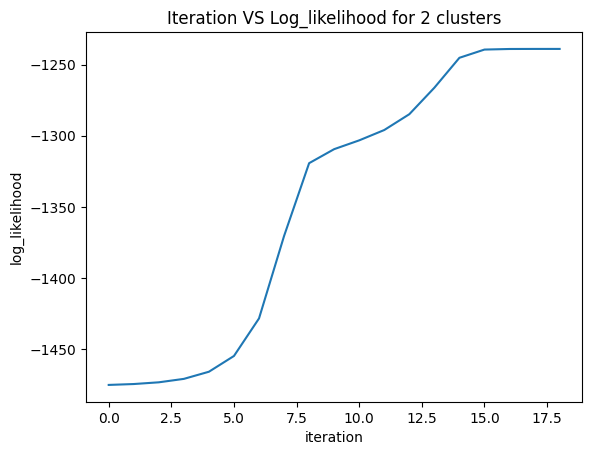

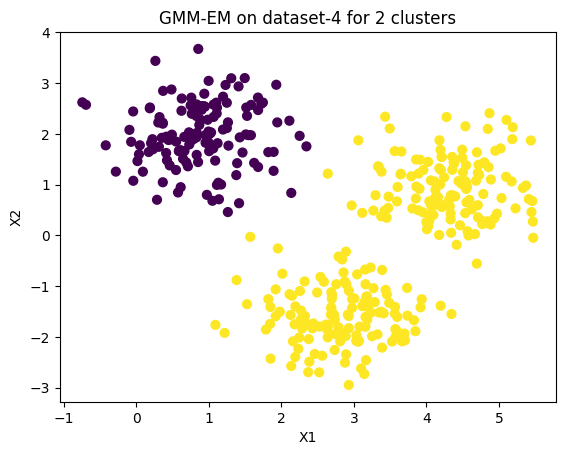

[ 2.81948979 -1.5912039 ]
[[0.37536603 0.00313869]
 [0.00313869 0.29239411]]
[4.3203726  0.93969773]
[[ 0.34085696 -0.00415508]
 [-0.00415508  0.35814604]]
[0.88626903 1.96165132]
[[0.35270209 0.00505417]
 [0.00505417 0.40142604]]
Clusters = 3


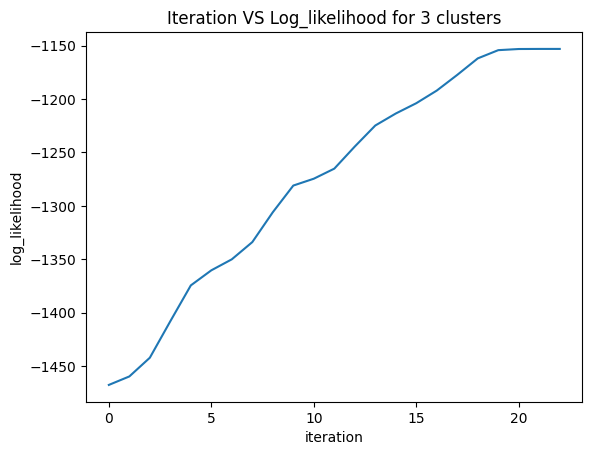

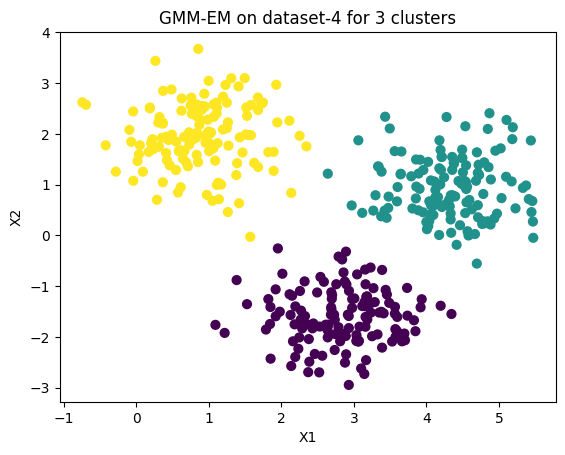

[ 2.82395829 -1.59731915]
[[0.37196766 0.00958652]
 [0.00958652 0.28472762]]
[0.97185674 1.81145103]
[[ 0.4790618  -0.10652381]
 [-0.10652381  0.53641164]]
[4.32692202 0.93862995]
[[ 0.33170455 -0.0025606 ]
 [-0.0025606   0.35867175]]
[0.80913548 2.11515866]
[[0.22150966 0.13518688]
 [0.13518688 0.23075602]]
Clusters = 4


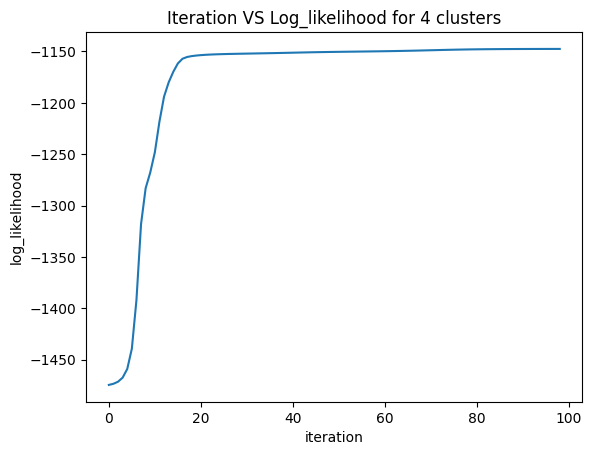

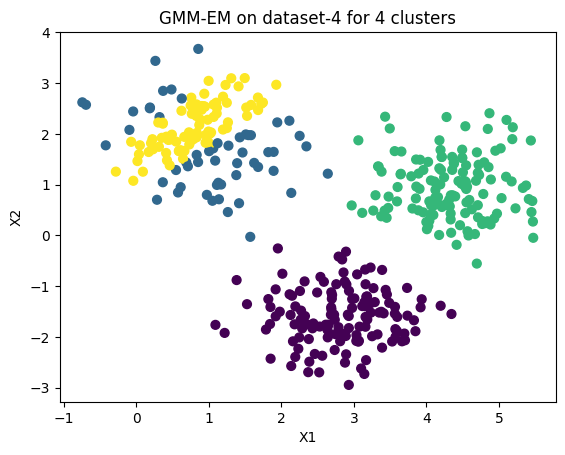

[0.81273667 2.07624868]
[[0.24752938 0.13268227]
 [0.13268227 0.32819021]]
[ 2.82402762 -1.59586807]
[[0.37155875 0.00887447]
 [0.00887447 0.28662639]]
[4.33485062 0.9359313 ]
[[0.32359946 0.00070854]
 [0.00070854 0.35827293]]
[1.1286826  1.85646279]
[[ 0.82528375 -0.20898317]
 [-0.20898317  0.2640798 ]]
[1.01597064 1.31007169]
[[ 0.12473109 -0.31875146]
 [-0.31875146  0.93888165]]
Clusters = 5


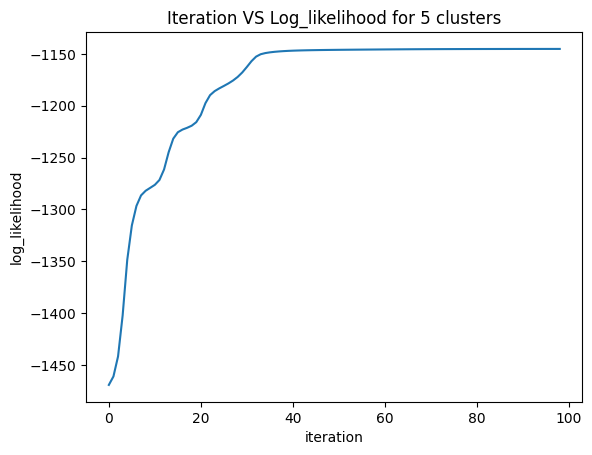

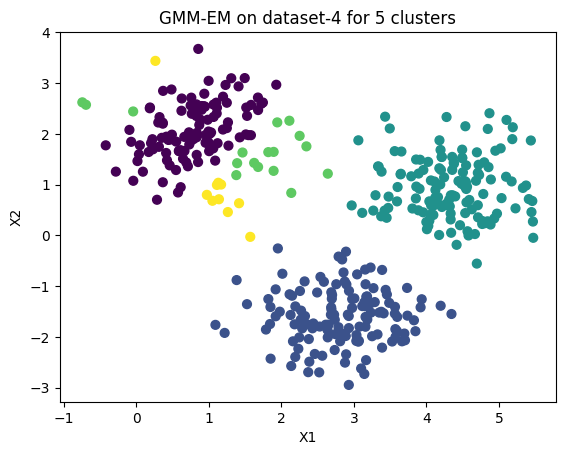

[0.7676985 2.0377544]
[[0.21314127 0.14279467]
 [0.14279467 0.27942298]]
[1.08214616 0.89949867]
[[ 0.18585817 -0.28336997]
 [-0.28336997  0.47112583]]
[1.0224656  2.03210962]
[[ 0.55825223 -0.10436889]
 [-0.10436889  0.38436848]]
[4.3809917  1.08392626]
[[ 0.29833825 -0.01887431]
 [-0.01887431  0.34058949]]
[ 2.8301276  -1.60183394]
[[0.37139193 0.01701669]
 [0.01701669 0.27907544]]
[4.14914293 0.40987367]
[[ 0.3921313  -0.06175912]
 [-0.06175912  0.04288532]]
Clusters = 6


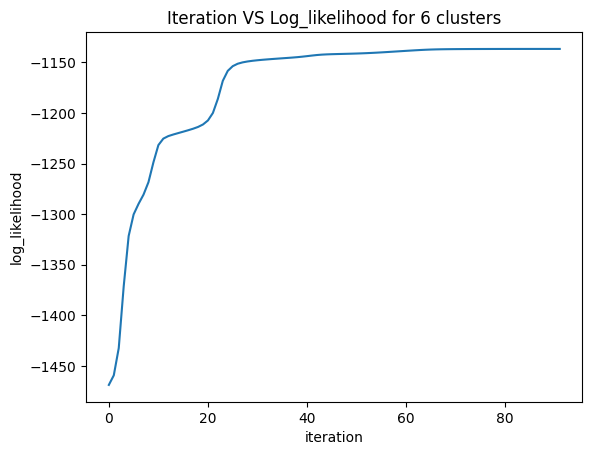

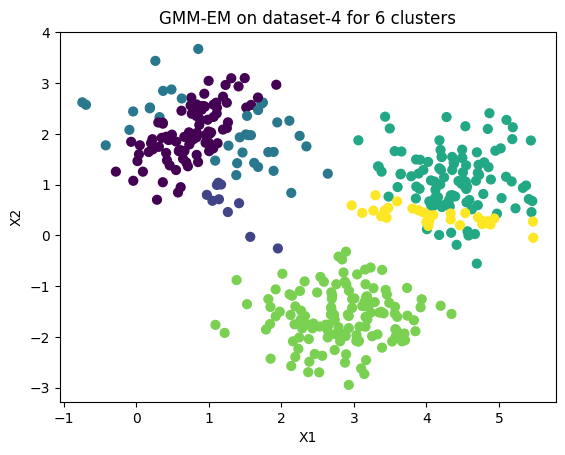

[1.04995438 2.05319797]
[[ 0.4654146  -0.03819824]
 [-0.03819824  0.33319865]]
[ 2.82860107 -1.6040699 ]
[[0.36978124 0.01588685]
 [0.01588685 0.27698267]]
[0.73796868 2.02603423]
[[0.21974435 0.1486952 ]
 [0.1486952  0.28594188]]
[1.09190526 1.68858805]
[[ 1.4131327  -0.70317624]
 [-0.70317624  0.39675954]]
[1.02233036 1.96226131]
[[ 0.00836372 -0.08095858]
 [-0.08095858  0.79678213]]
[1.2419334  0.58506472]
[[ 0.15931108 -0.20446561]
 [-0.20446561  0.29948264]]
[4.33542061 0.94095332]
[[ 0.3237301  -0.00436005]
 [-0.00436005  0.35915229]]
Clusters = 7


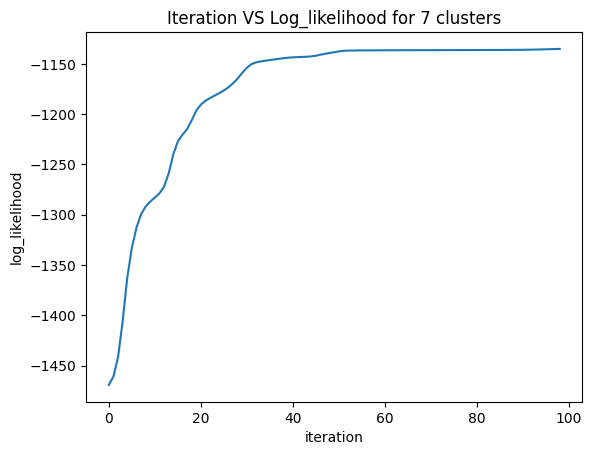

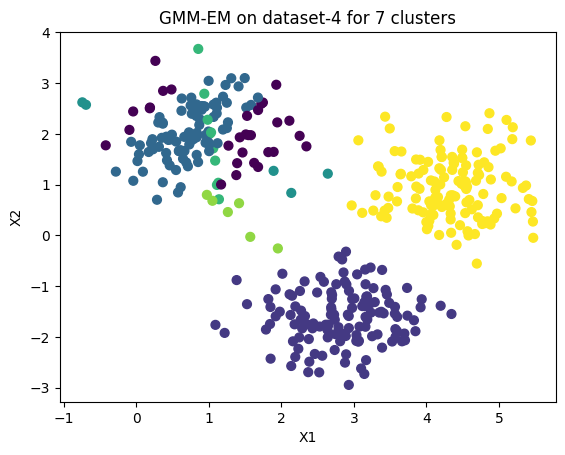

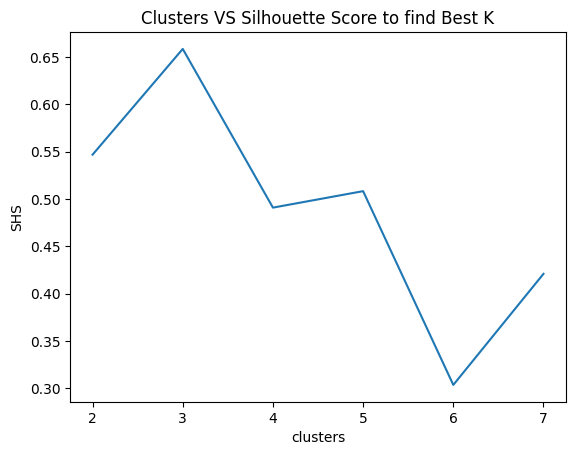

"plt.plot(x,y2)\nplt.xlabel('clusters')\nplt.ylabel('BIC')\n\nplt.show()"

In [17]:
x=[]
y1=[]
y2=[]

for i in range(2,8):
  obj=GMM(dat=data,k=i)
  scores=obj.run()

  x.append(i)
  y1.append(scores[0])
  y2.append(scores[1])

plt.plot(x,y1)
plt.title('Clusters VS Silhouette Score to find Best K')
plt.xlabel('clusters')
plt.ylabel('SHS')

plt.show()

"""plt.plot(x,y2)
plt.xlabel('clusters')
plt.ylabel('BIC')

plt.show()"""

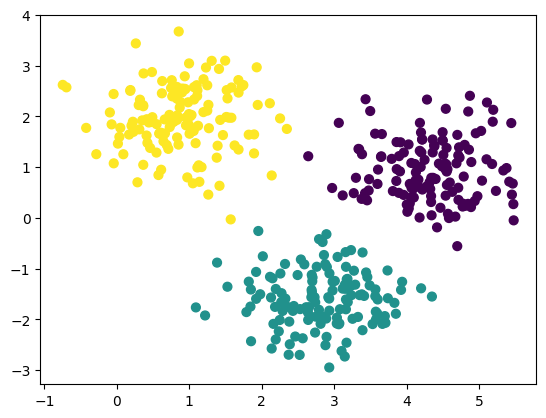

In [18]:
a=data.values.tolist()

b=[]
c=[]

for i in range(0,len(a)):
  b.append(a[i][0])
  c.append(a[i][1])

from sklearn import mixture
model = mixture.GaussianMixture(n_components=3, covariance_type='full')
model.fit(a)
labels = model.predict(a)
plt.scatter(b, c, c=labels, s=40, cmap='viridis');